In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from collections import Counter
import pickle
from joblib import dump, load

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 5.6 MB/s eta 0:00:03
     -------- ------------------------------- 2.6/12.8 MB 7.2 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 7.9 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 8.4 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 8.3 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 8.1 MB/s eta 0:00:01
     ------------------------------------ --- 11.5/12.8 MB 7.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\furmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\furmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Функция для получения отзывов из сообщества Steam, использует веб-API Steamworks. Возвращает таблицу с 15 колонками:

1. recommendationid - Уникальный ID рекомендации
2. author - Информация об авторе обзора
 1. steamid — SteamID пользователя
 2. num_games_owned — число игр, которыми владеет пользователь
 3. num_reviews — число обзоров, написанных пользователем
 4. playtime_forever — время, проведённое в этом приложении за всё время
 5. playtime_last_two_weeks — время, проведённое в этом приложении за две последние недели
 6. playtime_forever — время, проведённое в приложении на момент написания обзора
 7. deck_playtime_at_review — время, проведённое на Steam Deck на момент написания обзора
 8. last_played — время, когда пользователь запускал приложение в последний раз
3. language - Язык, указанный пользователем при написании обзора
4. review - Текст обзора
5. timestamp_created - Дата создания обзора в формате UNIX
6. timestamp_updated - Дата последнего изменения обзора в формате UNIX
7. voted_up - Значение true означает, что обзор положительный
8. votes_up - Число пользователей, посчитавших обзор полезным
9. votes_funny - Число пользователей, посчитавших обзор забавным
10. weighted_vote_score - Рейтинг полезности
11. comment_count - Число комментариев к этому обзору
12. steam_purchase - true, если пользователь купил игру в Steam
13. received_for_free - true, если пользователь поставил галочку, означающую, что он получил приложение бесплатно
14. written_during_early_access - true, если обзор написан, когда игра была в раннем доступе
15. primarily_steam_deck - Играл ли пользователь в эту игру в основном на Steam Deck на момент написания обзора

В качестве аргументов функция принимает id игры, число отзывов, которое будет в итоговой таблице, и язык, на котором написаны обзоры. Если указанное число отзывов превышает число отзывов в Steam, то некоторые отзывы будут продублированы.

In [4]:
def get_reviews(appid: str, num_reviews: int = 1000, language: str = 'english') -> pd.DataFrame:
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': language,
        'day_range': 365,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    while len(reviews) < num_reviews:
        params['cursor'] = cursor
        params['num_per_page'] = min(100, num_reviews - len(reviews))
        response = requests.get(
            url=f'https://store.steampowered.com/appreviews/{appid}',
            params=params
        )
        data = response.json()
        reviews.extend(data.get('reviews', []))
        cursor = data.get('cursor')
        if not cursor:
            break

    return pd.DataFrame(reviews)

In [ ]:
appid = input("Введите Steam AppID (цифры): ")
print("Загружаю отзывы... это может занять некоторое время.")
df = get_reviews(appid, num_reviews=150000)
print(f"Загружено отзывов: {len(df)}")
df.to_csv(f"steam_reviews_{appid}.csv", index=False)
print("Сохранено в CSV.")

 Чтобы постоянно не загружать наборы данных, было принято решение сохранить все полученные данные в формат csv. Таким образом при повторных запусках кода не придется заново получать все обзоры через API. Сохраненные наборы данных лежат в папке data

In [5]:
ER_df = pd.read_csv('./data/steam_reviews_EldenRing.csv')
ERDLC_df = pd.read_csv('./data/steam_reviews_EldenRingDLC.csv')
ERN_df = pd.read_csv('./data/steam_reviews_EldenRingNightreign.csv')

In [6]:
ER_df.info()
ERDLC_df.info()
ERN_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   recommendationid             50000 non-null  int64  
 1   author                       50000 non-null  object 
 2   language                     50000 non-null  object 
 3   review                       49993 non-null  object 
 4   timestamp_created            50000 non-null  int64  
 5   timestamp_updated            50000 non-null  int64  
 6   voted_up                     50000 non-null  bool   
 7   votes_up                     50000 non-null  int64  
 8   votes_funny                  50000 non-null  int64  
 9   weighted_vote_score          50000 non-null  float64
 10  comment_count                50000 non-null  int64  
 11  steam_purchase               50000 non-null  bool   
 12  received_for_free            50000 non-null  bool   
 13  written_during_e

In [7]:
ER_reviews_df = ER_df[['recommendationid','review','voted_up']].copy()
ER_reviews_df = ER_reviews_df.drop_duplicates().dropna()

ERDLC_reviews_df = ERDLC_df[['recommendationid','review','voted_up']].copy()
ERDLC_reviews_df = ERDLC_reviews_df.drop_duplicates().dropna()

ERN_reviews_df = ERN_df[['recommendationid','review','voted_up']].copy()
ERN_reviews_df = ERN_reviews_df.drop_duplicates().dropna()

In [8]:
ER_reviews_df.info()
ERDLC_reviews_df.info()
ERN_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49974 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   recommendationid  49974 non-null  int64 
 1   review            49974 non-null  object
 2   voted_up          49974 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 3897 entries, 0 to 15199
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   recommendationid  3897 non-null   int64 
 1   review            3897 non-null   object
 2   voted_up          3897 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 95.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 75072 entries, 0 to 149801
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   recommendationi

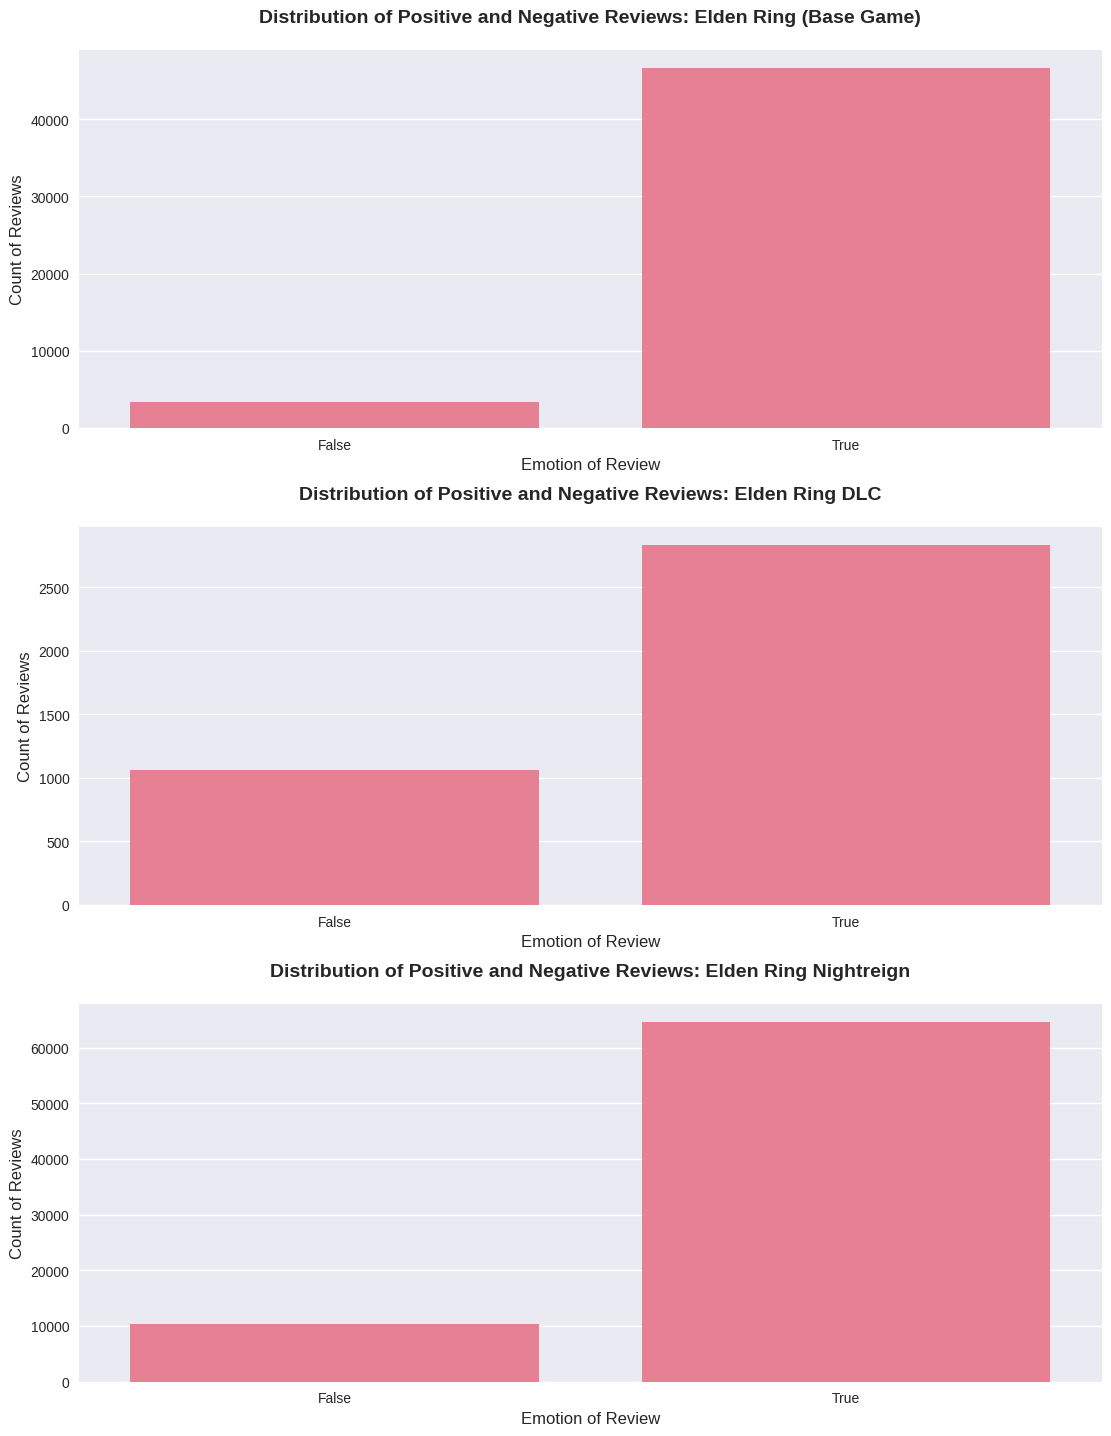

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.tight_layout(pad=5.0)


dfs = [ER_reviews_df, ERDLC_reviews_df, ERN_reviews_df]
titles = [
    'Distribution of Positive and Negative Reviews: Elden Ring (Base Game)',
    'Distribution of Positive and Negative Reviews: Elden Ring DLC',
    'Distribution of Positive and Negative Reviews: Elden Ring Nightreign'
]


for i, (df, title) in enumerate(zip(dfs, titles)):
    sns.countplot(df, x='voted_up', ax=ax[i])

    ax[i].set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax[i].set_xlabel('Emotion of Review', fontsize=12)
    ax[i].set_ylabel('Count of Reviews', fontsize=12)

plt.show()

In [9]:
url_pattern = re.compile(r'https?://\S+')
html_pattern = re.compile(r'\[[/A-Za-z0-9\*]+\]')

def remove_noise(text: str) -> str:
    text_without_urls = url_pattern.sub('', text)
    text_without_html = html_pattern.sub('', text_without_urls)
    return text_without_html.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')

In [10]:
ER_reviews_df['review'] = ER_reviews_df['review'].apply(lambda row: remove_noise(row))
ER_reviews_df['length'] = ER_reviews_df['review'].apply(lambda row: len(row))

ERDLC_reviews_df['review'] = ERDLC_reviews_df['review'].apply(lambda row: remove_noise(row))
ERDLC_reviews_df['length'] = ERDLC_reviews_df['review'].apply(lambda row: len(row))

ERN_reviews_df['review'] = ERN_reviews_df['review'].apply(lambda row: remove_noise(row))
ERN_reviews_df['length'] = ERN_reviews_df['review'].apply(lambda row: len(row))

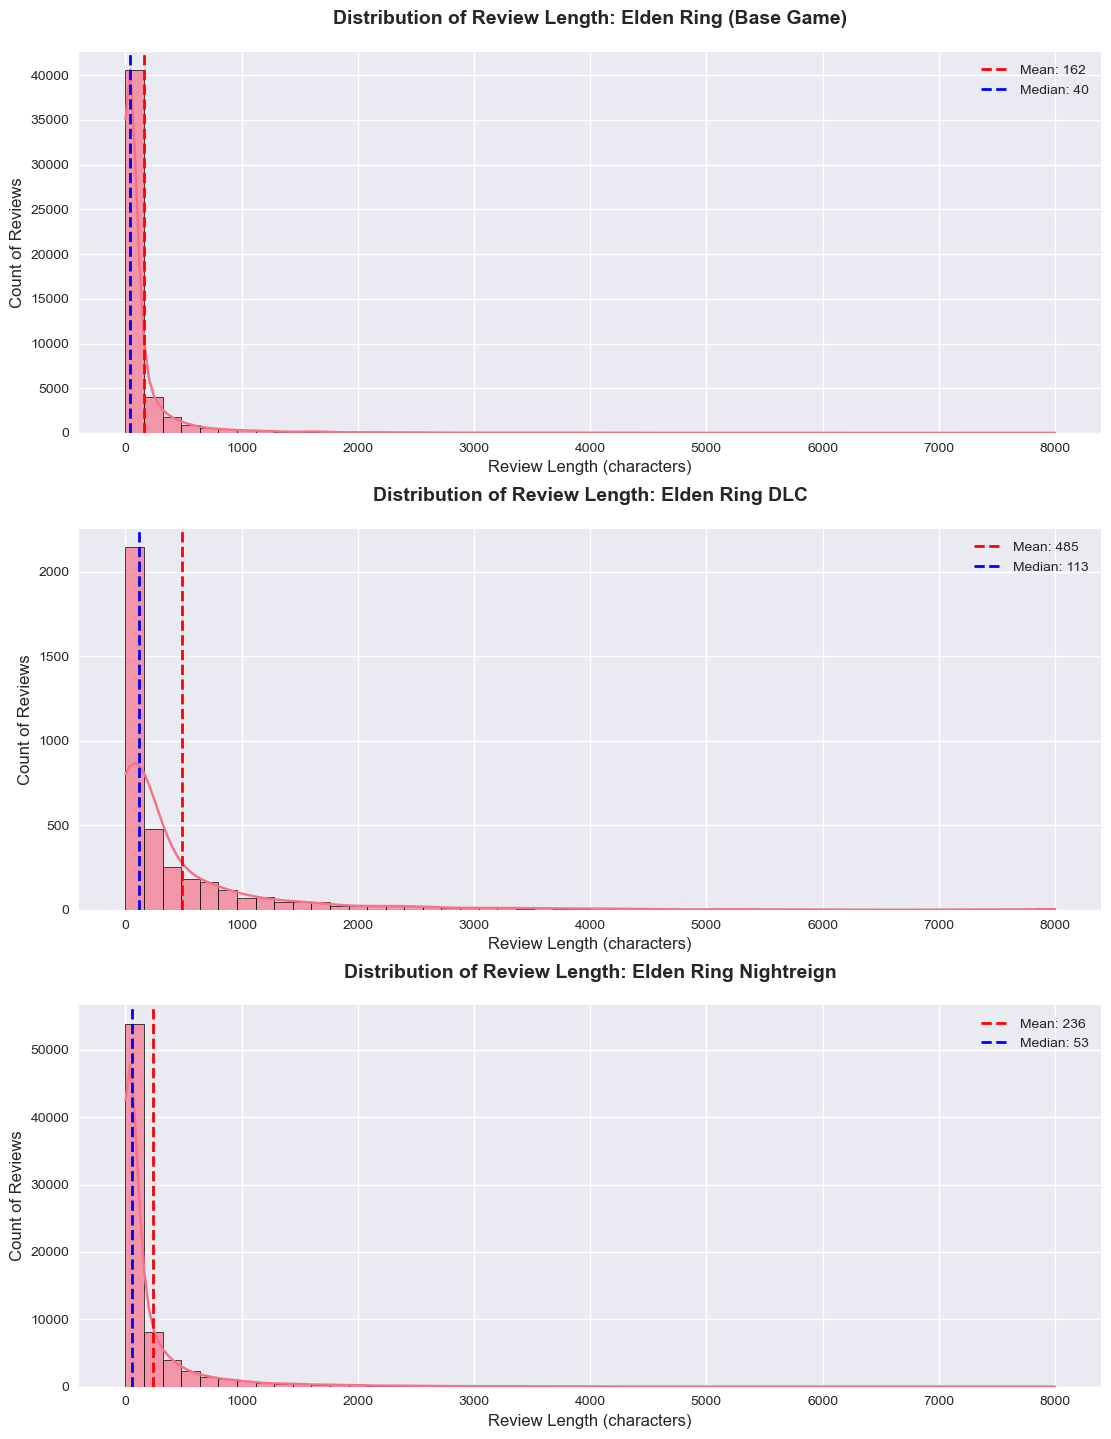

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
fig.tight_layout(pad=5.0)


dfs = [ER_reviews_df, ERDLC_reviews_df, ERN_reviews_df]
titles = [
    'Distribution of Review Length: Elden Ring (Base Game)',
    'Distribution of Review Length: Elden Ring DLC',
    'Distribution of Review Length: Elden Ring Nightreign'
]


for i, (df, title) in enumerate(zip(dfs, titles)):
    sns.histplot(df, x='length', ax=ax[i],
                 kde=True,
                 alpha=0.7,
                 bins=50,
                 edgecolor='black', linewidth=0.5)

    ax[i].set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax[i].set_xlabel('Review Length (characters)', fontsize=12)
    ax[i].set_ylabel('Count of Reviews', fontsize=12)
    mean_val = df['length'].mean()
    median_val = df['length'].median()
    ax[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.0f}')
    ax[i].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
    ax[i].legend()

plt.show()

In [12]:
punctuation_marks = string.punctuation
punctuation_marks_list = [char for char in punctuation_marks]
punctuation_marks_list.extend(['...', '..'])

nlp = spacy.load("en_core_web_sm")

stop_words = stopwords.words('english')

In [47]:
def preprocess(text, stop_words, punctuation_marks, morph):
    text = remove_noise(text)
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph(token)[0].lemma_
            if lemma not in stop_words and lemma not in punctuation_marks:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [14]:
ER_mid_reviews_df = ER_reviews_df.query('4 <= length <= 100').copy()
ERDLC_mid_reviews_df = ERDLC_reviews_df.query('4 <= length <= 100').copy()
ERN_mid_reviews_df = ERN_reviews_df.query('4 <= length <= 100').copy()

In [15]:
from tqdm import tqdm
tqdm.pandas()

ER_mid_reviews_df['preprocessed_review1'] = ER_mid_reviews_df['review'].progress_apply(lambda row:preprocess(row,stop_words,punctuation_marks, nlp) )
ERDLC_mid_reviews_df['preprocessed_review'] = ERDLC_mid_reviews_df['review'].progress_apply(lambda row:preprocess(row,stop_words,punctuation_marks, nlp) )
ERN_mid_reviews_df['preprocessed_review'] = ERN_mid_reviews_df['review'].progress_apply(lambda row:preprocess(row,stop_words,punctuation_marks, nlp) )

100%|██████████████████████████████████████████████████████████████████████████| 36205/36205 [1:35:43<00:00,  6.30it/s]
C:\Users\furmi\AppData\Local\Temp\ipykernel_15576\1527169825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ER_mid_reviews_df['preprocessed_review'] = ER_mid_reviews_df['review'].progress_apply(lambda row:preprocess(row,stop_words,punctuation_marks, nlp) )
100%|██████████████████████████████████████████████████████████████████████████████| 1784/1784 [05:21<00:00,  5.55it/s]
C:\Users\furmi\AppData\Local\Temp\ipykernel_15576\1527169825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [16]:
sorted_by_voted_df = ERN_mid_reviews_df.sort_values(by='voted_up').copy()
balanced_df = pd.concat([sorted_by_voted_df.head(2500), sorted_by_voted_df.tail(2500)])
balanced_df['voted_up'].value_counts()

voted_up
False    2500
True     2500
Name: count, dtype: int64

In [ ]:
balanced_df.head()

,recommendationid,review,voted_up,length,preprocessed_review
49061,195941528,still no ultrawide support,False,26,"[still, ultrawide, support]"
55557,197837277,chat we love crashes,False,20,"[chat, love, crash]"
66310,196685662,I HATE YOU,False,10,"[I, hate]"
55553,196138627,its slop,False,8,[slop]
55552,197290118,Not it,False,6,[]


In [17]:
words = Counter()

In [18]:
for txt in balanced_df['preprocessed_review']:
  words.update(txt)

In [19]:
word_to_index = dict()
index_to_word = dict()

In [20]:
for i, word in enumerate(words.most_common(10000-2)):
  word_to_index[word[0]] = i+2
  index_to_word[i+2] = word[0]

In [21]:
def text_to_sequence(txt, word_to_index):
  seq = []
  for word in txt:
    index = word_to_index.get(word,1)

    if index != 1:
      seq.append(index)
  return seq

In [22]:
balanced_df['Sequences'] = balanced_df['preprocessed_review'].apply(lambda x: text_to_sequence(x, word_to_index))

In [23]:
balanced_df['voted_up'] = balanced_df['voted_up'].astype(int)

In [24]:
def vectorize_sequences(sequences, dimension=10000):
  result = np.zeros((len(sequences),dimension))
  for i, sequence in enumerate(sequences):
    for index in sequence:
      result[i,index] += 1
  return result

In [25]:
lr = LogisticRegression(random_state=42,max_iter=500)

In [45]:
X = vectorize_sequences(balanced_df['Sequences'])
y = balanced_df['voted_up']

cv_results = cross_validate(lr, X, y)
sorted(cv_results.keys())
cv_results['test_score']

array([0.82 , 0.802, 0.791, 0.787, 0.789])

In [30]:
lr.fit(X,y)

LogisticRegression(max_iter=500, random_state=42)

In [ ]:
ERN_mid_reviews_df['Sequences'] = ERN_mid_reviews_df['preprocessed_review'].apply(lambda row: text_to_sequence(row, word_to_index))
ERDLC_mid_reviews_df['Sequences'] = ERDLC_mid_reviews_df['preprocessed_review'].apply(lambda row: text_to_sequence(row, word_to_index))
ER_mid_reviews_df['Sequences'] = ER_mid_reviews_df['preprocessed_review'].apply(lambda row: text_to_sequence(row, word_to_index))

ER_all_df = pd.concat([ERN_mid_reviews_df, ERDLC_mid_reviews_df, ER_mid_reviews_df])

X_test = vectorize_sequences(ER_all_df['Sequences'])
y_test = ER_all_df['voted_up']

In [50]:
lr.score(X_test, y_test)

0.7816566323557972

In [51]:
dump(lr, 'LogisticRegression.joblib')

['LogisticRegression.joblib']

In [52]:
def predict(texts):
  result = []
  for text in texts:
    text_preprocessed = preprocess(text,punctuation_marks_list,stop_words,nlp)
    sequenced_text = text_to_sequence(text_preprocessed,word_to_index)
    text_bow = vectorize_sequences([sequenced_text])
    result.append(lr.predict(text_bow)[0])
  return result

In [68]:
sentence1 = ER_all_df['review'].values[100]
is_voted = ER_all_df['voted_up'].values[100]
print(f'Исходный текст - {sentence1}')
print(f'Является отзыв положительным - {bool(predict([sentence1])[0])}')
print(f'Предсказание модели совпало с реальностью - {bool(predict([sentence1])[0]) == is_voted}')

Исходный текст - Very fun game, but game often crashes without reason, even on low settings.
Является отзыв положительным - False
Предсказание модели совпало с реальностью - True
